In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_19115/3983986288.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [8]:
with open('ei_intermediate_file_paths.json') as file_path_file:
    file_paths = json.load(file_path_file)


SI_PREDS_INPUT_PATH = file_paths.get("smoke_impact_model_predictions.csv")
NOAA_BLS_MERGED_INPUT_PATH = file_paths.get("stage2_fs_merged_output.csv")
EI_MODEL_INPUT_PATH = file_paths.get("ei_model_output")

EI_PREDS_OUTPUT_PATH = file_paths.get("economic_impact_model_predictions.csv")

In [9]:
# Load dataset
si_preds_df = pd.read_csv(SI_PREDS_INPUT_PATH)

noaa_bls_historical_df = pd.read_csv(NOAA_BLS_MERGED_INPUT_PATH)

In [5]:
print(si_preds_df.head(5))

print(si_preds_df.columns)

   year  predicted_total_acres_burned  predicted_avg_distance  \
0  2021                  2.351687e+06              359.010931   
1  2022                  2.351687e+06              359.010931   
2  2023                  2.351687e+06              359.010931   
3  2024                  2.351687e+06              359.010931   
4  2025                  2.351687e+06              359.010931   

   total_acres_burned_normalized  distance_normalized  \
0                       0.483929             0.552325   
1                       0.483929             0.552325   
2                       0.483929             0.552325   
3                       0.483929             0.552325   
4                       0.483929             0.552325   

   total_acres_burned_weighted  distance_weighted  predicted_smoke_impact  
0                     0.483929           0.552325               34.902199  
1                     0.483929           0.552325               34.902199  
2                     0.483929        

In [6]:
print(noaa_bls_historical_df.head(5))

print(noaa_bls_historical_df.columns)

         date    bls_date  bls_curr_sae_hrs  bls_curr_laus_labor_force  \
0  2009-09-01  2009-09-01              36.8                   421301.0   
1  2009-10-01  2009-10-01              36.7                   422913.0   
2  2010-05-01  2010-05-01              38.0                   415895.0   
3  2010-06-01  2010-06-01              37.9                   421034.0   
4  2010-07-01  2010-07-01              37.4                   423239.0   

   bls_curr_laus_unemployment_rate  bls_prev_yr_sae_hrs  \
0                              9.1                 37.4   
1                              8.8                 37.0   
2                              8.2                 37.4   
3                              8.7                 37.9   
4                              8.4                 37.1   

   bls_prev_yr_laus_labor_force  bls_prev_yr_laus_unemployment_rate  \
0                      427171.0                                 5.8   
1                      431740.0                           

In [ ]:
# Convert the date column to datetime and extract month and year
noaa_bls_historical_df['date'] = pd.to_datetime(noaa_bls_historical_df['date'])
noaa_bls_historical_df['month'] = noaa_bls_historical_df['date'].dt.month
noaa_bls_historical_df['year'] = noaa_bls_historical_df['date'].dt.year

# Calculate 5-year rolling averages for each variable, considering only data from May to October for each year
noaa_bls_historical_df = noaa_bls_historical_df[noaa_bls_historical_df['month'].isin([5, 6, 7, 8, 9, 10])]

# Select relevant columns for grouping
group_columns = ['year', 'month','noaa_tavg', 'noaa_prcp', 'bls_pct_diff_sae_hrs', 'bls_pct_diff_laus_labor_force']
noaa_bls_historical_df = noaa_bls_historical_df[group_columns]

# yearly_avg_df = noaa_bls_historical_df.groupby('year').mean().reset_index()

In [ ]:
# Calculate monthly averages by year and month
monthly_avg_df = noaa_bls_historical_df.groupby(['year', 'month']).mean().reset_index()

# %% [Modified Calculating 3-Year Rolling Averages]
# Add 3-year rolling averages for May–October data
monthly_avg_df['3yr_avg_tavg'] = (
    monthly_avg_df.sort_values(by=['month', 'year'])  # Ensure data is sorted by month and year
    .groupby('month')['noaa_tavg']
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(drop=True)
)

monthly_avg_df['3yr_avg_prcp'] = (
    monthly_avg_df.sort_values(by=['month', 'year'])
    .groupby('month')['noaa_prcp']
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(drop=True)
)

monthly_avg_df['3yr_avg_pct_diff_sae_hrs'] = (
    monthly_avg_df.sort_values(by=['month', 'year'])
    .groupby('month')['bls_pct_diff_sae_hrs']
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(drop=True)
)

monthly_avg_df['3yr_avg_pct_diff_labor_force'] = (
    monthly_avg_df.sort_values(by=['month', 'year'])
    .groupby('month')['bls_pct_diff_laus_labor_force']
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(drop=True)
)




In [ ]:
print(monthly_avg_df.head(5))

print(monthly_avg_df.columns)

In [ ]:
# %% [Modified Forecasting Future Data]
# Generate rows for May–October months for 2025–2050
future_months = pd.date_range(start="2025-05-01", end="2050-10-31", freq='MS')
future_predictions = pd.DataFrame({
    'year': future_months.year,
    'month': future_months.month,
    'predicted_tavg': np.nan,
    'predicted_prcp': np.nan,
    'predicted_pct_diff_sae_hrs': np.nan,
    'predicted_pct_diff_labor_force': np.nan
})

In [ ]:
# Copy historical data into a temporary DataFrame to simulate adding future data
temp_data = monthly_avg_df.copy()

# %% [Modified Simulating Rolling Averages]
cycle_length = 3 * 6  # 3 years * 6 months per year (rolling window for monthly data)

for i, row in future_predictions.iterrows():
    # Assign predictions for this month based on the latest 3-year averages
    future_predictions.loc[i, 'predicted_tavg'] = temp_data['3yr_avg_tavg'].iloc[-1]
    future_predictions.loc[i, 'predicted_prcp'] = temp_data['3yr_avg_prcp'].iloc[-1]
    future_predictions.loc[i, 'predicted_pct_diff_sae_hrs'] = temp_data['3yr_avg_pct_diff_sae_hrs'].iloc[-1]
    future_predictions.loc[i, 'predicted_pct_diff_labor_force'] = temp_data['3yr_avg_pct_diff_labor_force'].iloc[-1]

    # Every cycle_length (18 months), update rolling averages
    if (i + 1) % cycle_length == 0:
        # Create a new row for the latest predictions as "historical" data
        new_row = pd.DataFrame({
            'year': [row['year']],
            'month': [row['month']],
            'noaa_tavg': [future_predictions.loc[i, 'predicted_tavg']],
            'noaa_prcp': [future_predictions.loc[i, 'predicted_prcp']],
            'bls_pct_diff_sae_hrs': [future_predictions.loc[i, 'predicted_pct_diff_sae_hrs']],
            'bls_pct_diff_laus_labor_force': [future_predictions.loc[i, 'predicted_pct_diff_labor_force']]
        })

        # Concatenate the new row to `temp_data`
        temp_data = pd.concat([temp_data, new_row], ignore_index=True)

        # Recalculate the 3-year rolling averages
        temp_data['3yr_avg_tavg'] = (
            temp_data.sort_values(by=['month', 'year'])
            .groupby('month')['noaa_tavg']
            .rolling(window=3, min_periods=1)
            .mean()
            .reset_index(drop=True)
        )
        temp_data['3yr_avg_prcp'] = (
            temp_data.sort_values(by=['month', 'year'])
            .groupby('month')['noaa_prcp']
            .rolling(window=3, min_periods=1)
            .mean()
            .reset_index(drop=True)
        )
        temp_data['3yr_avg_pct_diff_sae_hrs'] = (
            temp_data.sort_values(by=['month', 'year'])
            .groupby('month')['bls_pct_diff_sae_hrs']
            .rolling(window=3, min_periods=1)
            .mean()
            .reset_index(drop=True)
        )
        temp_data['3yr_avg_pct_diff_labor_force'] = (
            temp_data.sort_values(by=['month', 'year'])
            .groupby('month')['bls_pct_diff_laus_labor_force']
            .rolling(window=3, min_periods=1)
            .mean()
            .reset_index(drop=True)
        )

In [ ]:
future_predictions = future_predictions.merge(si_preds_df[['year', 'predicted_smoke_impact']], on='year', how='left')


In [ ]:
print(future_predictions)

In [ ]:
# Load the trained model
with open(EI_MODEL_INPUT_PATH, 'rb') as model_file:
    economic_impact_model = pickle.load(model_file)

# Remap column names to the expected names for the model
future_predictions.rename(columns={
    'predicted_smoke_impact': 'scaled_avg_daily_smoke_impact',
    'predicted_tavg': 'noaa_tavg',
    'predicted_prcp': 'noaa_prcp',
    'predicted_pct_diff_sae_hrs': 'bls_pct_diff_sae_hrs',
    'predicted_pct_diff_labor_force': 'bls_pct_diff_laus_labor_force'
}, inplace=True)

In [ ]:
print(future_predictions.head(5))

print(future_predictions.columns)

In [ ]:
# Prepare the data for prediction
# Select the required features for the model
prediction_features = ['noaa_tavg', 'noaa_prcp', 'scaled_avg_daily_smoke_impact', 'bls_pct_diff_sae_hrs', 'bls_pct_diff_laus_labor_force']

In [ ]:
# Ensure future_predictions includes the required columns
X_future = future_predictions[prediction_features]

print(X_future)

# X_future.to_csv("X_future.csv")

In [ ]:
# Check for NaN values in the prediction features
nan_columns = future_predictions[prediction_features].isna().sum()

# Print columns with NaN values
print("Columns with NaN values and their counts:")
print(nan_columns[nan_columns > 0])


In [ ]:
# Make predictions using the loaded model
future_predictions['pct_diff_laus_unemployment_rate'] = economic_impact_model.predict(X_future)

In [ ]:
# Display the predictions
print(future_predictions)

In [ ]:
# Plot the predicted unemployment rate
plt.figure(figsize=(10, 6))
plt.plot(future_predictions['year'], future_predictions['pct_diff_laus_unemployment_rate'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Predicted % Difference in LAUS Unemployment Rate')
plt.title('Predicted % Difference in LAUS Unemployment Rate Over Time')
plt.ylim(None, 0)  # Set the y-axis to start at 0 and let it scale automatically for the upper limit
plt.grid(True)
plt.show()


In [ ]:
# Save the predictions to the output CSV file
future_predictions.to_csv(EI_PREDS_OUTPUT_PATH, index=False)
print(f"Predictions saved to {EI_PREDS_OUTPUT_PATH}")

## MIGHT NEED TO CHANGE IT TO THIS

In [21]:
# %% [Filter for May–October]

noaa_bls_historical_df = pd.read_csv(NOAA_BLS_MERGED_INPUT_PATH)

print(noaa_bls_historical_df.head(5))

print(noaa_bls_historical_df.columns)

         date    bls_date  bls_curr_sae_hrs  bls_curr_laus_labor_force  \
0  2009-09-01  2009-09-01              36.8                   421301.0   
1  2009-10-01  2009-10-01              36.7                   422913.0   
2  2010-05-01  2010-05-01              38.0                   415895.0   
3  2010-06-01  2010-06-01              37.9                   421034.0   
4  2010-07-01  2010-07-01              37.4                   423239.0   

   bls_curr_laus_unemployment_rate  bls_prev_yr_sae_hrs  \
0                              9.1                 37.4   
1                              8.8                 37.0   
2                              8.2                 37.4   
3                              8.7                 37.9   
4                              8.4                 37.1   

   bls_prev_yr_laus_labor_force  bls_prev_yr_laus_unemployment_rate  \
0                      427171.0                                 5.8   
1                      431740.0                           

In [22]:
noaa_bls_historical_df['date'] = pd.to_datetime(noaa_bls_historical_df['date'])

In [23]:
noaa_bls_historical_df['month'] = noaa_bls_historical_df['date'].dt.month
noaa_bls_historical_df['year'] = noaa_bls_historical_df['date'].dt.year
fire_season_data = noaa_bls_historical_df[noaa_bls_historical_df['month'].isin([5, 6, 7, 8, 9, 10])]

In [24]:
# Ensure only May–October data is included

group_columns = ['year','noaa_tavg', 'noaa_prcp', 'bls_pct_diff_sae_hrs', 'bls_pct_diff_laus_labor_force']
fire_season_data = fire_season_data[group_columns]

# %% [Group by Year and Calculate Annual Averages for May–October]
annual_avg = fire_season_data.groupby('year').mean().reset_index()

In [25]:


# %% [3-Year Moving Average]
# Calculate 3-year moving averages for relevant columns
annual_avg['3yr_avg_tavg'] = annual_avg['noaa_tavg'].rolling(window=3, min_periods=1).mean()
annual_avg['3yr_avg_prcp'] = annual_avg['noaa_prcp'].rolling(window=3, min_periods=1).mean()
annual_avg['3yr_avg_pct_diff_sae_hrs'] = annual_avg['bls_pct_diff_sae_hrs'].rolling(window=3, min_periods=1).mean()
annual_avg['3yr_avg_pct_diff_labor_force'] = annual_avg['bls_pct_diff_laus_labor_force'].rolling(window=3, min_periods=1).mean()

# %% [Prepare Future Predictions]
# Generate rows for future years
future_years = range(2025, 2051)
future_predictions = pd.DataFrame({
    'year': future_years,
    'predicted_tavg': np.nan,
    'predicted_prcp': np.nan,
    'predicted_pct_diff_sae_hrs': np.nan,
    'predicted_pct_diff_labor_force': np.nan
})

# Use the last available 3-year moving average values to predict future data
for i, row in future_predictions.iterrows():
    future_predictions.loc[i, 'predicted_tavg'] = annual_avg['3yr_avg_tavg'].iloc[-1]
    future_predictions.loc[i, 'predicted_prcp'] = annual_avg['3yr_avg_prcp'].iloc[-1]
    future_predictions.loc[i, 'predicted_pct_diff_sae_hrs'] = annual_avg['3yr_avg_pct_diff_sae_hrs'].iloc[-1]
    future_predictions.loc[i, 'predicted_pct_diff_labor_force'] = annual_avg['3yr_avg_pct_diff_labor_force'].iloc[-1]

# %% [Merge with Smoke Impact Predictions]
# Merge with smoke impact predictions on the year
future_predictions = future_predictions.merge(si_preds_df[['year', 'predicted_smoke_impact']], on='year', how='left')

# Rename columns to align with the economic impact model expectations
future_predictions.rename(columns={
    'predicted_smoke_impact': 'scaled_avg_daily_smoke_impact',
    'predicted_tavg': 'noaa_tavg',
    'predicted_prcp': 'noaa_prcp',
    'predicted_pct_diff_sae_hrs': 'bls_pct_diff_sae_hrs',
    'predicted_pct_diff_labor_force': 'bls_pct_diff_laus_labor_force'
}, inplace=True)

# %% [Prepare Data for Prediction]
# Select features required for the model



In [28]:
# Load the trained Gradient Boosting model
with open(EI_MODEL_INPUT_PATH , 'rb') as model_file:
    economic_impact_model = pickle.load(model_file)

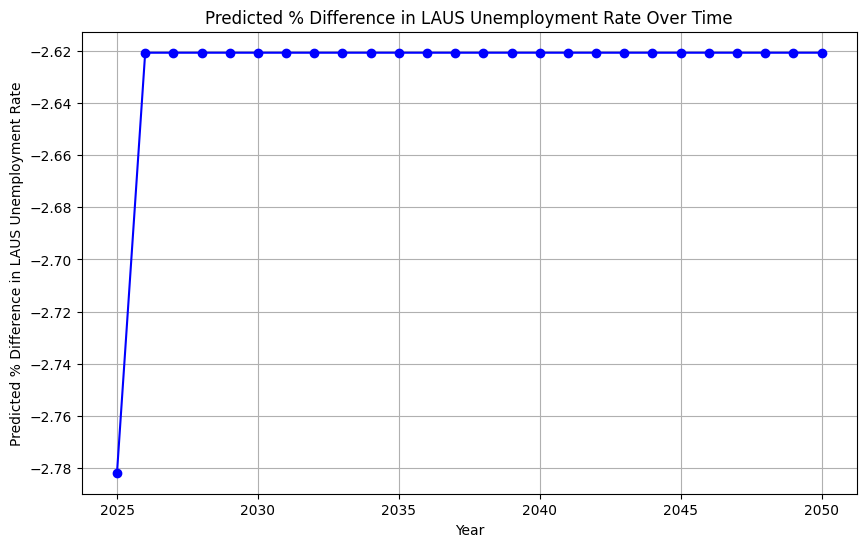

Predictions saved to final-output/economic_impact_estimate_mdl_future_prediction.csv


In [29]:
prediction_features = ['noaa_tavg', 'noaa_prcp', 'scaled_avg_daily_smoke_impact', 'bls_pct_diff_sae_hrs', 'bls_pct_diff_laus_labor_force']

# Extract features for prediction
X_future = future_predictions[prediction_features]

# %% [Make Predictions]
future_predictions['pct_diff_laus_unemployment_rate'] = economic_impact_model.predict(X_future)

# %% [Plot Predictions]
plt.figure(figsize=(10, 6))
plt.plot(future_predictions['year'], future_predictions['pct_diff_laus_unemployment_rate'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Predicted % Difference in LAUS Unemployment Rate')
plt.title('Predicted % Difference in LAUS Unemployment Rate Over Time')
plt.grid(True)
plt.show()

# %% [Save Predictions]
future_predictions.to_csv(EI_PREDS_OUTPUT_PATH, index=False)
print(f"Predictions saved to {EI_PREDS_OUTPUT_PATH}")